# Efficient Net

Chest Data

In [43]:
from __future__ import print_function

import glob
import os
import random
import cv2
import time

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from PIL import Image
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from torchvision.transforms import v2
from tqdm.notebook import tqdm

from pathlib import Path
import seaborn as sns
import timm
from pprint import pprint
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt

In [44]:
# Training settings
epochs = 100
lr = 0.001

In [45]:
#device = 'cuda'
device = 'cpu'

train_dataset_dir = Path('./data/Gender01/train')
val_dataset_dir = Path('./data/Gender01/validation')
test_dataset_dir = Path('./data/Gender01/test')

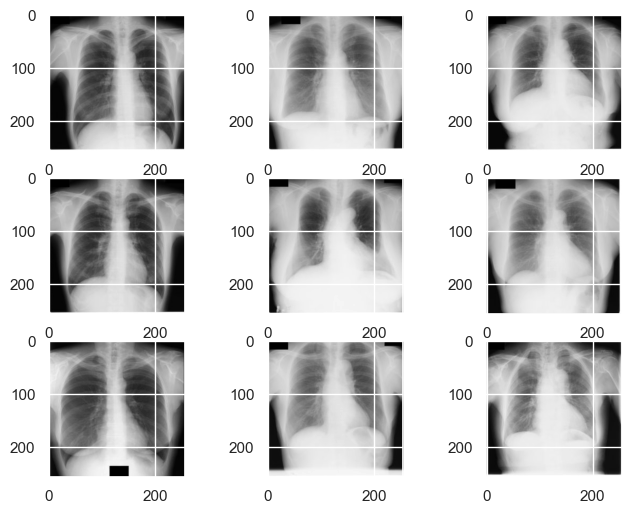

In [46]:
files = glob.glob('./data/Gender01/*/*/*.png')
random_idx = np.random.randint(1, len(files), size=9)
fig, axes = plt.subplots(3, 3, figsize=(8, 6))

for idx, ax in enumerate(axes.ravel()):
    img = Image.open(files[idx])
    ax.imshow(img, cmap='gray')

In [47]:
train_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]
)

val_transforms = transforms.Compose(
    [
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]
)

test_transforms = transforms.Compose(
    [
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]
)

In [48]:
train_data = datasets.ImageFolder(train_dataset_dir,train_transforms)
valid_data = datasets.ImageFolder(val_dataset_dir, val_transforms)
test_data = datasets.ImageFolder(test_dataset_dir, test_transforms)

In [49]:
train_loader = DataLoader(dataset = train_data, batch_size=16, shuffle=True )
valid_loader = DataLoader(dataset = valid_data, batch_size=16, shuffle=False)
test_loader = DataLoader(dataset = test_data, batch_size=16, shuffle=False)

In [50]:
model_names = timm.list_models(pretrained=True)
pprint(model_names)

['bat_resnext26ts.ch_in1k',
 'beit_base_patch16_224.in22k_ft_in22k',
 'beit_base_patch16_224.in22k_ft_in22k_in1k',
 'beit_base_patch16_384.in22k_ft_in22k_in1k',
 'beit_large_patch16_224.in22k_ft_in22k',
 'beit_large_patch16_224.in22k_ft_in22k_in1k',
 'beit_large_patch16_384.in22k_ft_in22k_in1k',
 'beit_large_patch16_512.in22k_ft_in22k_in1k',
 'beitv2_base_patch16_224.in1k_ft_in1k',
 'beitv2_base_patch16_224.in1k_ft_in22k',
 'beitv2_base_patch16_224.in1k_ft_in22k_in1k',
 'beitv2_large_patch16_224.in1k_ft_in1k',
 'beitv2_large_patch16_224.in1k_ft_in22k',
 'beitv2_large_patch16_224.in1k_ft_in22k_in1k',
 'botnet26t_256.c1_in1k',
 'caformer_b36.sail_in1k',
 'caformer_b36.sail_in1k_384',
 'caformer_b36.sail_in22k',
 'caformer_b36.sail_in22k_ft_in1k',
 'caformer_b36.sail_in22k_ft_in1k_384',
 'caformer_m36.sail_in1k',
 'caformer_m36.sail_in1k_384',
 'caformer_m36.sail_in22k',
 'caformer_m36.sail_in22k_ft_in1k',
 'caformer_m36.sail_in22k_ft_in1k_384',
 'caformer_s18.sail_in1k',
 'caformer_s18.s

In [51]:
model = timm.create_model('tf_efficientnetv2_s_in21ft1k', pretrained=True, num_classes=2)
model = model.to(device)

c:\Users\tkurita1958\AppData\Local\anaconda3\Lib\site-packages\timm\models\_factory.py:117: UserWarning: Mapping deprecated model name tf_efficientnetv2_s_in21ft1k to current tf_efficientnetv2_s.in21k_ft_in1k.
  model = create_fn(


In [57]:
from torchsummary import summary
print(model)

summary(model, (3, 224, 224))

EfficientNet(
  (conv_stem): Conv2dSame(3, 24, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn1): BatchNormAct2d(
    24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): SiLU(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): ConvBnAct(
        (conv): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNormAct2d(
          24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (aa): Identity()
        (drop_path): Identity()
      )
      (1): ConvBnAct(
        (conv): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNormAct2d(
          24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (aa): Identity()
        (drop_path):

In [52]:
# loss function
criterion = nn.CrossEntropyLoss()
# optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)

In [53]:
best_loss = None

# Accuracy計算用の関数
def calculate_accuracy(output, target):
    output = (torch.sigmoid(output) >= 0.5)
    target = (target == 1.0)
    accuracy = torch.true_divide((target == output).sum(dim=0), output.size(0)).item()
    return accuracy

train_acc_list = []
val_acc_list = []
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0

    for data, label in tqdm(train_loader):
        data = data.to(device)
        label = label.to(device)

        output = model(data)
        loss = criterion(output, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        acc = (output.argmax(dim=1) == label).float().mean()
        epoch_accuracy += acc / len(train_loader)
        epoch_loss += loss / len(train_loader)              

    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for data, label in valid_loader:
            data = data.to(device)
            label = label.to(device)

            val_output = model(data)
            val_loss = criterion(val_output, label)

            acc = (val_output.argmax(dim=1) == label).float().mean()
            epoch_val_accuracy += acc / len(valid_loader)
            epoch_val_loss += val_loss / len(valid_loader)

    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
    )

    train_acc_list.append(epoch_accuracy)
    val_acc_list.append(epoch_val_accuracy)
    train_loss_list.append(epoch_loss)
    val_loss_list.append(epoch_val_loss)

    if (best_loss is None) or (best_loss > val_loss):
        best_loss = val_loss
        model_path = './trained_models/bestmodel_efficientnet.pth'
        torch.save(model.state_dict(), model_path)
        
    print()

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 1 - loss : 2.5542 - acc: 0.7675 - val_loss : 12.3393 - val_acc: 0.5655




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 2 - loss : 3.3124 - acc: 0.8563 - val_loss : 9.1739 - val_acc: 0.5565




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 3 - loss : 1.1436 - acc: 0.8900 - val_loss : 5.1038 - val_acc: 0.5298




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 4 - loss : 0.5111 - acc: 0.9313 - val_loss : 6.2098 - val_acc: 0.6042




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 5 - loss : 0.4127 - acc: 0.9688 - val_loss : 6.8534 - val_acc: 0.5536




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 6 - loss : 0.0784 - acc: 0.9813 - val_loss : 4.5227 - val_acc: 0.6161




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 7 - loss : 0.3662 - acc: 0.9688 - val_loss : 3.6404 - val_acc: 0.6399




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 8 - loss : 0.0179 - acc: 0.9938 - val_loss : 4.1607 - val_acc: 0.6399




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 9 - loss : 0.0186 - acc: 0.9875 - val_loss : 3.7599 - val_acc: 0.5982




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 10 - loss : 0.0885 - acc: 0.9900 - val_loss : 3.8128 - val_acc: 0.5982




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 11 - loss : 0.1618 - acc: 0.9563 - val_loss : 4.9234 - val_acc: 0.6667




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 12 - loss : 0.0081 - acc: 1.0000 - val_loss : 6.6240 - val_acc: 0.6696




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 13 - loss : 0.0045 - acc: 1.0000 - val_loss : 7.7476 - val_acc: 0.6667




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 14 - loss : 0.0000 - acc: 1.0000 - val_loss : 8.4238 - val_acc: 0.7113




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 15 - loss : 0.0612 - acc: 0.9875 - val_loss : 8.9419 - val_acc: 0.7113




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 16 - loss : 0.0002 - acc: 1.0000 - val_loss : 8.0685 - val_acc: 0.6667




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 17 - loss : 0.0013 - acc: 1.0000 - val_loss : 7.9087 - val_acc: 0.6875




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 18 - loss : 0.0119 - acc: 0.9938 - val_loss : 7.3953 - val_acc: 0.6905




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 19 - loss : 0.0042 - acc: 1.0000 - val_loss : 7.4934 - val_acc: 0.6905




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 20 - loss : 0.0076 - acc: 1.0000 - val_loss : 8.5004 - val_acc: 0.7113




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 21 - loss : 0.0021 - acc: 1.0000 - val_loss : 9.3483 - val_acc: 0.7113




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 22 - loss : 0.2561 - acc: 0.9613 - val_loss : 7.6923 - val_acc: 0.6935




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 23 - loss : 0.1275 - acc: 0.9625 - val_loss : 8.1355 - val_acc: 0.6726




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 24 - loss : 0.4262 - acc: 0.9563 - val_loss : 8.8576 - val_acc: 0.5506




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 25 - loss : 0.1100 - acc: 0.9813 - val_loss : 6.8558 - val_acc: 0.6071




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 26 - loss : 0.1456 - acc: 0.9813 - val_loss : 5.5706 - val_acc: 0.6786




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 27 - loss : 0.0531 - acc: 0.9875 - val_loss : 6.1761 - val_acc: 0.7381




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 28 - loss : 0.0532 - acc: 0.9938 - val_loss : 7.5439 - val_acc: 0.6667




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 29 - loss : 0.0516 - acc: 0.9712 - val_loss : 7.2663 - val_acc: 0.6280




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 30 - loss : 0.2258 - acc: 0.9688 - val_loss : 5.1673 - val_acc: 0.7202




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 31 - loss : 0.0089 - acc: 0.9900 - val_loss : 6.0084 - val_acc: 0.6429




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 32 - loss : 0.0065 - acc: 0.9938 - val_loss : 5.5234 - val_acc: 0.6488




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 33 - loss : 0.0000 - acc: 1.0000 - val_loss : 5.4584 - val_acc: 0.6756




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 34 - loss : 0.0011 - acc: 1.0000 - val_loss : 5.5044 - val_acc: 0.6756




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 35 - loss : 0.0007 - acc: 1.0000 - val_loss : 5.5853 - val_acc: 0.6964




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 36 - loss : 0.0001 - acc: 1.0000 - val_loss : 5.6494 - val_acc: 0.6964




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 37 - loss : 0.0000 - acc: 1.0000 - val_loss : 5.6755 - val_acc: 0.6964




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 38 - loss : 0.0000 - acc: 1.0000 - val_loss : 5.6871 - val_acc: 0.6964




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 39 - loss : 0.0005 - acc: 1.0000 - val_loss : 5.6905 - val_acc: 0.6964




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 40 - loss : 0.0077 - acc: 1.0000 - val_loss : 5.7754 - val_acc: 0.6756




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 41 - loss : 0.0070 - acc: 0.9900 - val_loss : 6.3976 - val_acc: 0.6964




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 42 - loss : 0.0003 - acc: 1.0000 - val_loss : 7.3218 - val_acc: 0.6964




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 43 - loss : 0.0006 - acc: 1.0000 - val_loss : 7.5699 - val_acc: 0.6726




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 44 - loss : 0.0006 - acc: 1.0000 - val_loss : 7.6458 - val_acc: 0.6726




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 45 - loss : 0.0002 - acc: 1.0000 - val_loss : 7.6682 - val_acc: 0.6726




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 46 - loss : 0.0000 - acc: 1.0000 - val_loss : 7.6762 - val_acc: 0.6726




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 47 - loss : 0.0003 - acc: 1.0000 - val_loss : 7.6779 - val_acc: 0.6726




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 48 - loss : 0.0001 - acc: 1.0000 - val_loss : 7.6818 - val_acc: 0.6726




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 49 - loss : 0.0002 - acc: 1.0000 - val_loss : 7.6837 - val_acc: 0.6964




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 50 - loss : 0.0001 - acc: 1.0000 - val_loss : 7.6849 - val_acc: 0.6964




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 51 - loss : 0.0005 - acc: 1.0000 - val_loss : 7.6811 - val_acc: 0.7202




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 52 - loss : 0.0000 - acc: 1.0000 - val_loss : 7.6775 - val_acc: 0.7202




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 53 - loss : 0.0065 - acc: 1.0000 - val_loss : 7.4023 - val_acc: 0.6964




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 54 - loss : 0.0001 - acc: 1.0000 - val_loss : 6.0320 - val_acc: 0.6756




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 55 - loss : 0.0054 - acc: 0.9938 - val_loss : 5.8202 - val_acc: 0.7381




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 56 - loss : 0.0000 - acc: 1.0000 - val_loss : 5.7696 - val_acc: 0.7143




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 57 - loss : 0.0000 - acc: 1.0000 - val_loss : 5.7940 - val_acc: 0.6935




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 58 - loss : 0.0000 - acc: 1.0000 - val_loss : 5.8178 - val_acc: 0.7143




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 59 - loss : 0.0001 - acc: 1.0000 - val_loss : 5.8358 - val_acc: 0.7143




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 60 - loss : 0.0000 - acc: 1.0000 - val_loss : 5.8451 - val_acc: 0.7143




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 61 - loss : 0.0000 - acc: 1.0000 - val_loss : 5.8485 - val_acc: 0.7143




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 62 - loss : 0.0000 - acc: 1.0000 - val_loss : 5.8505 - val_acc: 0.7143




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 63 - loss : 0.0000 - acc: 1.0000 - val_loss : 5.8534 - val_acc: 0.7143




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 64 - loss : 0.0000 - acc: 1.0000 - val_loss : 5.8596 - val_acc: 0.7143




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 65 - loss : 0.0000 - acc: 1.0000 - val_loss : 5.8627 - val_acc: 0.7143




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 66 - loss : 0.0000 - acc: 1.0000 - val_loss : 5.8640 - val_acc: 0.7143




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 67 - loss : 0.0001 - acc: 1.0000 - val_loss : 5.8821 - val_acc: 0.7143




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 68 - loss : 0.0000 - acc: 1.0000 - val_loss : 5.8892 - val_acc: 0.7143




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 69 - loss : 0.0000 - acc: 1.0000 - val_loss : 5.8920 - val_acc: 0.7143




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 70 - loss : 0.0000 - acc: 1.0000 - val_loss : 5.8944 - val_acc: 0.7143




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 71 - loss : 0.0000 - acc: 1.0000 - val_loss : 5.8959 - val_acc: 0.7143




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 72 - loss : 0.0000 - acc: 1.0000 - val_loss : 5.8983 - val_acc: 0.7143




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 73 - loss : 0.0000 - acc: 1.0000 - val_loss : 5.9003 - val_acc: 0.7143




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 74 - loss : 0.0000 - acc: 1.0000 - val_loss : 5.9010 - val_acc: 0.7143




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 75 - loss : 0.0000 - acc: 1.0000 - val_loss : 5.9000 - val_acc: 0.7143




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 76 - loss : 0.0000 - acc: 1.0000 - val_loss : 5.9004 - val_acc: 0.7143




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 77 - loss : 0.0000 - acc: 1.0000 - val_loss : 5.9021 - val_acc: 0.7143




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 78 - loss : 0.0000 - acc: 1.0000 - val_loss : 5.9033 - val_acc: 0.7143




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 79 - loss : 0.0000 - acc: 1.0000 - val_loss : 5.9039 - val_acc: 0.7143




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 80 - loss : 0.0000 - acc: 1.0000 - val_loss : 5.9059 - val_acc: 0.7143




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 81 - loss : 0.0000 - acc: 1.0000 - val_loss : 5.9123 - val_acc: 0.7143




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 82 - loss : 0.0000 - acc: 1.0000 - val_loss : 5.9156 - val_acc: 0.7143




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 83 - loss : 0.0000 - acc: 1.0000 - val_loss : 5.9248 - val_acc: 0.7143




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 84 - loss : 0.0000 - acc: 1.0000 - val_loss : 5.9326 - val_acc: 0.7143




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 85 - loss : 0.0000 - acc: 1.0000 - val_loss : 5.9372 - val_acc: 0.7143




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 86 - loss : 0.0000 - acc: 1.0000 - val_loss : 5.9405 - val_acc: 0.7143




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 87 - loss : 0.0000 - acc: 1.0000 - val_loss : 5.9422 - val_acc: 0.7143




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 88 - loss : 0.0000 - acc: 1.0000 - val_loss : 5.9440 - val_acc: 0.7143




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 89 - loss : 0.0001 - acc: 1.0000 - val_loss : 5.9425 - val_acc: 0.7143




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 90 - loss : 0.0000 - acc: 1.0000 - val_loss : 5.9407 - val_acc: 0.7143




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 91 - loss : 0.0000 - acc: 1.0000 - val_loss : 5.9402 - val_acc: 0.7143




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 92 - loss : 0.0000 - acc: 1.0000 - val_loss : 5.9402 - val_acc: 0.7143




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 93 - loss : 0.0000 - acc: 1.0000 - val_loss : 5.9403 - val_acc: 0.7143




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 94 - loss : 0.0000 - acc: 1.0000 - val_loss : 5.9405 - val_acc: 0.7143




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 95 - loss : 0.0000 - acc: 1.0000 - val_loss : 5.9431 - val_acc: 0.7143




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 96 - loss : 0.0001 - acc: 1.0000 - val_loss : 6.0061 - val_acc: 0.7143




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 97 - loss : 0.0000 - acc: 1.0000 - val_loss : 6.0378 - val_acc: 0.7143




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 98 - loss : 0.0000 - acc: 1.0000 - val_loss : 6.0492 - val_acc: 0.7143




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 99 - loss : 0.0000 - acc: 1.0000 - val_loss : 6.0532 - val_acc: 0.7143




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 100 - loss : 0.0000 - acc: 1.0000 - val_loss : 6.0552 - val_acc: 0.7143




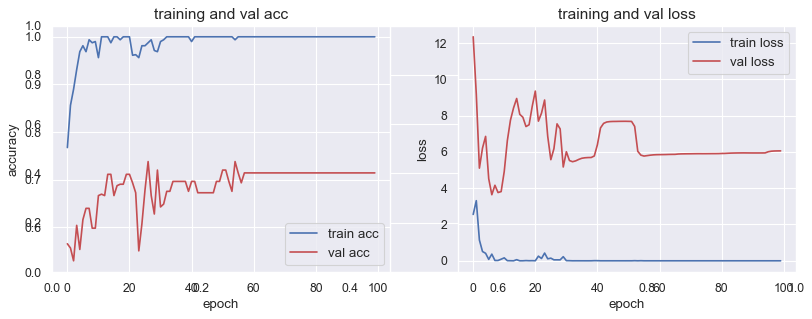

In [54]:
device2 = torch.device('cpu')

train_acc = []
train_loss = []
val_acc = []
val_loss = []

for i in range(epochs):
    train_acc2 = train_acc_list[i].to(device2)
    train_acc3 = train_acc2.clone().numpy()
    train_acc.append(train_acc3)
    
    train_loss2 = train_loss_list[i].to(device2)
    train_loss3 = train_loss2.clone().detach().numpy()
    train_loss.append(train_loss3)
    
    val_acc2 = val_acc_list[i].to(device2)
    val_acc3 = val_acc2.clone().numpy()
    val_acc.append(val_acc3)
    
    val_loss2 = val_loss_list[i].to(device2)
    val_loss3 = val_loss2.clone().numpy()
    val_loss.append(val_loss3)

#取得したデータをグラフ化する
sns.set()
num_epochs = epochs

fig = plt.subplots(figsize=(12, 4), dpi=80)

ax1 = plt.subplot(1,2,1)
ax1.plot(range(num_epochs), train_acc, c='b', label='train acc')
ax1.plot(range(num_epochs), val_acc, c='r', label='val acc')
ax1.set_xlabel('epoch', fontsize='12')
ax1.set_ylabel('accuracy', fontsize='12')
ax1.set_title('training and val acc', fontsize='14')
ax1.legend(fontsize='12')

ax2 = plt.subplot(1,2,2)
ax2.plot(range(num_epochs), train_loss, c='b', label='train loss')
ax2.plot(range(num_epochs), val_loss, c='r', label='val loss')
ax2.set_xlabel('epoch', fontsize='12')
ax2.set_ylabel('loss', fontsize='12')
ax2.set_title('training and val loss', fontsize='14')
ax2.legend(fontsize='12')
plt.show()

C:\Users\tkurita1958\AppData\Local\Temp\ipykernel_5256\1147987467.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("./trained_models/best

Accuracy: 0.9574
感度: 0.9615
特異度: 0.9524
PPV: 0.9615
NPV: 0.9524
F-Score: 0.9615
AUC: 0.9634


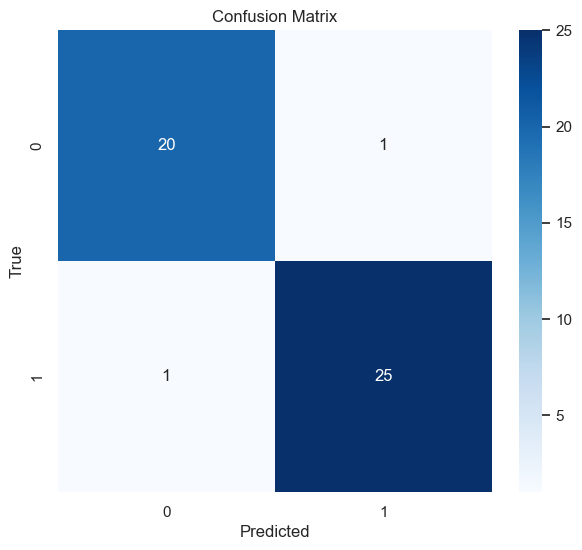

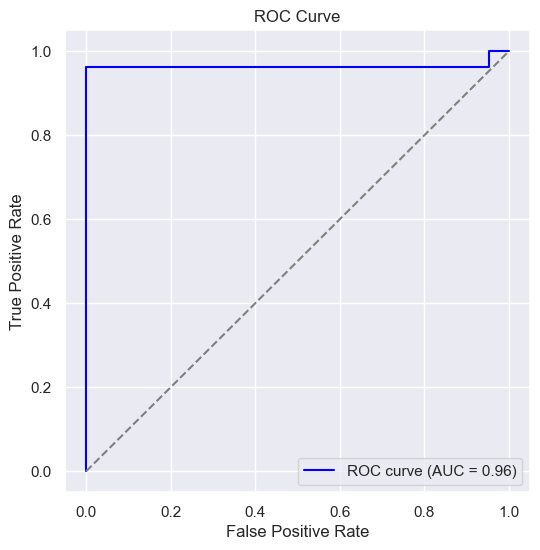

In [55]:
def evaluate_model(model, test_loader):
    model.load_state_dict(torch.load("./trained_models/bestmodel_efficientnet.pth"))
    model.eval()
    predictions = []
    actuals = []
    probas = []
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            probas.extend(outputs[:, 1].cpu().numpy())  # 二番目のクラス（陽性クラス）の確率
            predictions.extend(predicted.cpu().numpy())
            actuals.extend(labels.cpu().numpy())


    # 指標の計算
    confusion = confusion_matrix(actuals, predictions)
    accuracy = accuracy_score(actuals, predictions)
    recall = recall_score(actuals, predictions)  # 感度
    specificity = recall_score(actuals, predictions, pos_label=0)
    precision = precision_score(actuals, predictions)  # PPV
    npv = precision_score(actuals, predictions, pos_label=0)  # NPV
    f1 = f1_score(actuals, predictions)
    auc = roc_auc_score(actuals, probas)


    #print("混同行列:\n", confusion)
    print(f"Accuracy: {accuracy:.4f}")
    print(f"感度: {recall:.4f}")
    print(f"特異度: {specificity:.4f}")
    print(f"PPV: {precision:.4f}")
    print(f"NPV: {npv:.4f}")
    print(f"F-Score: {f1:.4f}")
    print(f"AUC: {auc:.4f}")


    # Confusion matrixの描画
    # 混同行列の可視化
    plt.figure(figsize=(7, 6))
    sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix")
    plt.ylabel("True")
    plt.xlabel("Predicted")
    plt.show()


    # ROC曲線の描画
    fpr, tpr, thresholds = roc_curve(actuals, probas)
    plt.figure(figsize=(6,6))
    plt.plot(fpr, tpr, color='blue', label='ROC curve (AUC = %0.2f)' % auc)
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()


evaluate_model(model, test_loader)